In [15]:
import os
import cv2
import shutil

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from scipy.stats import rayleigh
from tqdm import tqdm

from glob import glob

# Unenhanced Image

In [2]:
img_folder = "C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/imgs/"

img_list = glob(os.path.join(img_folder, "*.jpg"))

print(len(img_list))

1149


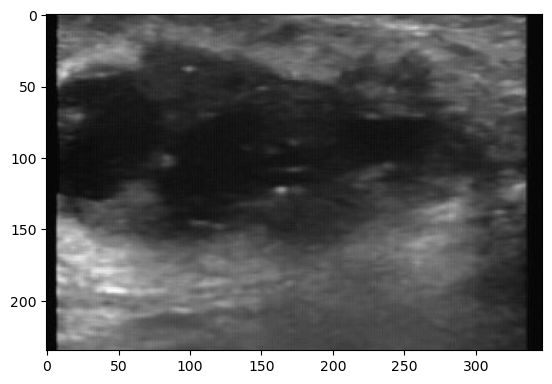

In [3]:
# Load an image
# img = plt.imread(img_list[0])
img = cv2.imread(img_list[0], cv2.IMREAD_GRAYSCALE)

# Show the raw image
plt.imshow(img, cmap="gray")

# Default OpenCV CLAHE: Uniform Distribution + Bilinear Interpolation

In [4]:
def clahe_cv(img, clip_limit=2.0, grid_size=(8,8)):
    # Convert the image to grayscale (if it's not already)
    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    img_clahe = clahe.apply(img)

    return img_clahe

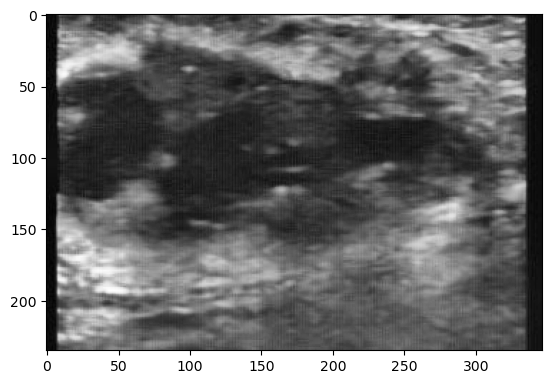

In [5]:
# Perform CLAHE
img_clahe_cv2 = clahe_cv(img)

# Show the image after default cv2 CLAHE
plt.imshow(img_clahe_cv2, cmap="gray")

# CLAHE: Rayleigh distribution + lanczos_interpolation

In [6]:
def rayleigh_clahe(img, clip_limit=2.0, tile_grid_size=(8,8)):
    # Convert to float for processing
    img = img.astype(np.float64)
    
    # Normalize the image to range [0,1]
    img /= np.max(img)
    
    # Create a CLAHE object (Arguments are optional)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    img_clahe = clahe.apply((img*255).astype(np.uint8))
    
    # Calculate scale for Rayleigh distribution based on the image
    scale = np.std(img_clahe)
    
    # Flatten the image for processing
    img_flat = img_clahe.flatten()
    
    # Generate Rayleigh distributed histogram
    rayleigh_hist, bin_edges = np.histogram(rayleigh.rvs(scale=scale, size=len(img_flat)), bins=256)
    
    # Generate the histogram of the input image
    img_hist, _ = np.histogram(img_flat, bins=256)
    
    # Calculate the CDFs
    img_cdf = img_hist.cumsum() / img_hist.sum()
    rayleigh_cdf = rayleigh_hist.cumsum() / rayleigh_hist.sum()
    
    # Perform histogram matching
    img_matched = np.interp(img_flat, bin_edges[:-1], rayleigh_cdf)
    
    # Map the matched image to the CDF of the original image
    img_matched = np.interp(img_matched, img_cdf, bin_edges[:-1])
    
    # Reshape the image back to its original shape
    img_matched = img_matched.reshape(img.shape)
    
    return img_matched

def lanczos_interpolation(img, zoom_factor):
    # Perform Lanczos-3 interpolation
    img_interpolated = zoom(img, zoom_factor, order=3)
    
    return img_interpolated


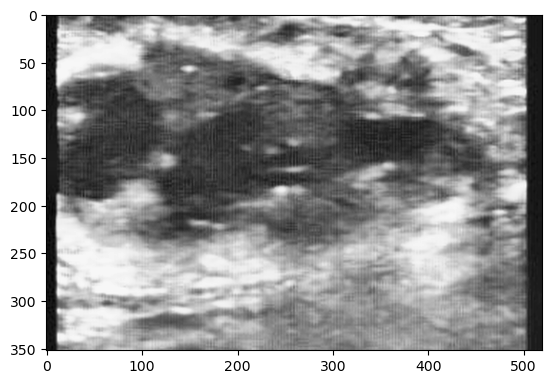

In [7]:
# Perform CLAHE with Rayleigh distribution
img_eq = rayleigh_clahe(img)

# Perform Lanczos-3 interpolation
# img_interpolated = lanczos_interpolation(img_eq, 1.5)  # zoom by 1.5x
img_interpolated = lanczos_interpolation(img_eq, 1)  # No Zoom in

# Display the result
plt.imshow(img_interpolated, cmap="gray")

# Create CLAHE Default Dataset

In [8]:
split_images_path = "C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/texts_split_binary/images/"

In [10]:
img_split_list = glob(os.path.join(split_images_path, "*/*.jpg"))
print(len(img_split_list))

1149


In [19]:
output_path = "C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/imgs_clahe_default/"

# Default CLAHE with OpenCV
for img_path in tqdm(img_split_list):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_enhanced = clahe_cv(img)

    if img_path.split("\\")[-2] == "train":
        # Save the image to train folder
        cv2.imwrite(os.path.join(output_path, 'train/' + os.path.basename(img_path)), img_enhanced)
    elif img_path.split("\\")[-2] == "val":
        # Save the image to val folder
        cv2.imwrite(os.path.join(output_path, 'val/' + os.path.basename(img_path)), img_enhanced)

100%|██████████| 1149/1149 [00:14<00:00, 78.75it/s]


# Create CLAHE Best Practice (Rayleigh Dist. + lanczos int.)

In [22]:
output_path = "C:/Users/frank/OneDrive/Desktop/GT_Practicum/data/preprocessed/AI+_processed/imgs_clahe_best_practice/"
for img_path in tqdm(img_split_list):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_eq = rayleigh_clahe(img)
    img_interpolated = lanczos_interpolation(img_eq, 1)  # No Zoom in

    if img_path.split("\\")[-2] == "train":
        # Save the image to train folder
        cv2.imwrite(os.path.join(output_path, 'train/' + os.path.basename(img_path)), img_interpolated)
    elif img_path.split("\\")[-2] == "val":
        # Save the image to val folder
        cv2.imwrite(os.path.join(output_path, 'val/' + os.path.basename(img_path)), img_interpolated)

100%|██████████| 1149/1149 [01:20<00:00, 14.25it/s]
